In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import fbeta_score
from sklearn.preprocessing import LabelEncoder
import re
from torch.utils.data import DataLoader, Dataset
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
data_rare = pd.read_csv('data_rare.csv', index_col=[0])

In [3]:
data_rare.loc[~data_rare['handshake'].isna(), 'is_handshake'] = 1
data_rare.loc[data_rare['is_handshake'].isna(), 'is_handshake'] = 0

In [4]:
fingerprint = []
alert_message = []
certificate = []
is_selfsigned = []

for i in range(0, len(data_rare)):
    fingerprint.append(len(re.findall('fingerprint', data_rare['handshake'].fillna('0')[i], flags=0)))
    alert_message.append(len(re.findall('alert_message', data_rare['packets'].fillna('0')[i], flags=0)))
    certificate.append(len(re.findall('certificate', data_rare['handshake'].fillna('0')[i], flags=0)))
    is_selfsigned.append(len(re.findall("'is_selfsigned': True", data_rare['handshake'].fillna('0')[i], flags=0)))

data_rare['fingerprint'] = fingerprint
data_rare['alert_message'] = alert_message
data_rare['certificate'] = certificate
data_rare['is_selfsigned'] = is_selfsigned

In [5]:
data_rare['country'] = pd.read_csv('data.csv')['country']

In [6]:
data_rare = data_rare.drop('index', axis=1)

In [7]:
X = data_rare.drop(['packets', 'timestamps', 'anomaly', 'handshake'], axis=1)

In [8]:
X['addr_1'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_1']

X['addr_2'] = pd.DataFrame(list(X['addr'].str.split('.').values), columns = ['addr_1',
                                                        'addr_2',
                                                        'addr_3', 
                                                        'addr_4'])['addr_2']

In [9]:
X_new = X.drop(['proto', 'addr_1', 'addr_2', 'country', 'addr'], 
                     axis=1).merge(pd.get_dummies(X[['proto', 'country', 'addr_1', 'addr_2']], drop_first = True),
                                                    left_index = True, right_index=True)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_new, data_rare['anomaly'], random_state = 42, test_size = 0.3)

In [11]:
# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Преобразование данных в тензоры
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float)

### 1 подход

In [12]:
# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 10

# Создание модели, оптимизатора и функции потерь
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1).type_as(outputs))
    loss.backward()
    optimizer.step()

# Оценка модели с помощью Fbeta_score
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    preds = (test_outputs > 0).int()
    targets = y_test.int()

# Оценка с использованием Fbeta_score
fbeta = fbeta_score(targets, preds, beta=1.5)

print("Fbeta_score on test data:", fbeta)

Fbeta_score on test data: 0.0


Странно получилось, посмотрим вообще на все предсказания.

In [13]:
preds.unique()

tensor([0], dtype=torch.int32)

Причина в том, что на наших данных нейронка выдает константный прогноз = 0

### 2 подход
Возможно, причина в дизбалансе классов. У меня данных с аномалиями всего 5%. 
Используем параметр pos_weight в функции потерь nn.BCEWithLogitsLoss, чтобы учитывать дисбаланс классов. Установив вес для класса 1 равным 19, мы помогаем модели более эффективно обучаться на дисбалансированных данных.

In [14]:
# Определение нейронной сети
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Параметры
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
learning_rate = 0.001
num_epochs = 10

# Создание модели, оптимизатора и взвешенной функции потерь
model = NeuralNetwork(input_size, hidden_size, output_size)
pos_weight = torch.tensor([19.0])  # Устанавливаем вес для класса 1
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train.unsqueeze(1).type_as(outputs))
    loss.backward()
    optimizer.step()

# Оценка модели с помощью Fbeta_score
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    preds = (test_outputs > 0).int()
    targets = y_test.int()

# Оценка с использованием Fbeta_score
fbeta = fbeta_score(targets, preds, beta=1.5)

print("Fbeta_score on test data:", fbeta)

Fbeta_score on test data: 0.0


In [15]:
preds.unique()

tensor([0], dtype=torch.int32)

Тоже не сработало.

### Попробуем ребалансировку классов
Просто использовали алгоритм SMOTE для ресемплирования данных и балансировки классов перед обучением модели.

In [16]:
# Создание экземпляра SMOTE
sm = SMOTE(random_state=42)

# Ресемплирование тренировочных данных
X_train_resampled, y_train_resampled = sm.fit_resample(np.nan_to_num(X_train), np.nan_to_num(y_train))

# Преобразование в тензоры PyTorch
X_train_resampled = torch.FloatTensor(X_train_resampled)
y_train_resampled = torch.FloatTensor(y_train_resampled)

# Создание модели, оптимизатора и критерия потерь
model = NeuralNetwork(input_size, hidden_size, output_size)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели на ресемплированных данных
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_resampled)
    loss = criterion(outputs, y_train_resampled.unsqueeze(1))
    loss.backward()
    optimizer.step()

# Оценка модели с помощью Fbeta_score
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    preds = (test_outputs > 0).int()
    targets = y_test.int()

# Оценка с использованием Fbeta_score
fbeta = fbeta_score(targets, preds, beta=1.5)

print("Fbeta_score on test data:", fbeta)

Fbeta_score on test data: 0.5136859436097962


In [17]:
preds.unique()

tensor([0, 1], dtype=torch.int32)

In [93]:
sum(targets)

tensor(371, dtype=torch.int32)

In [94]:
len(targets) - sum(targets)

tensor(5361, dtype=torch.int32)

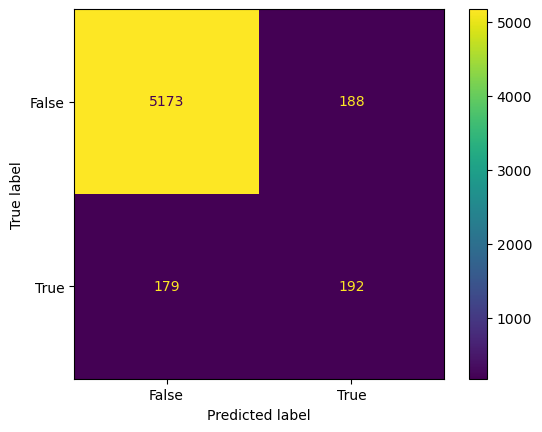

In [91]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

confusion_matrix = confusion_matrix(targets.squeeze().tolist(), preds.squeeze().tolist())

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

Кажется, это лучше, но все еще качество недотягивает до нашей финальной ml модели. Аномалии угадывает совсем плохо, чаще не угадывает.

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_new, data_rare['anomaly'], random_state = 42, test_size = 0.3)

# Нормализация данных
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Создание экземпляра SMOTE
sm = SMOTE(random_state=42)

In [178]:
# Определение класса для автоэнкодера
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Преобразование данных в формат PyTorch Dataset
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Загрузка данных и определение параметров
input_dim = X_train.shape[1]
encoding_dim = 128  # Увеличили размер скрытого слоя
epochs = 50
batch_size = 64

# Создание и обучение автоэнкодера
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.L1Loss()  # Использовали функцию потерь L1Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = CustomDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for data in train_loader:
        optimizer.zero_grad()
        recon = model(data)
        loss = criterion(recon, data)
        loss.backward()
        optimizer.step()

# Ресемплинг данных
smote = SMOTE(sampling_strategy=0.05)
X_train_resampled, y_train_resampled = sm.fit_resample(np.nan_to_num(X_train), np.nan_to_num(y_train))

test_dataset = CustomDataset(X_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

reconstructions = []
model.eval()
with torch.no_grad():
    for data in test_loader:
        recon = model(data)
        reconstructions.extend(recon.tolist())

# Расчет потерь между входными данными и реконструированными данными
losses = [criterion(torch.tensor(rec), torch.tensor(data)) for rec, data in zip(reconstructions, test_dataset)]

# Порог для определения аномалий
threshold = np.percentile(losses, 0.5)

# Преобразование потерь в метки
y_pred = [1 if loss > threshold else 0 for loss in losses]

# Подсчет Fbeta_score
fbeta = fbeta_score(y_test, y_pred, beta=1.5)

print(f"Fbeta_score на тесте: {fbeta}")

C:\Users\60135487\AppData\Local\Temp\ipykernel_21984\1023183091.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  losses = [criterion(torch.tensor(rec), torch.tensor(data)) for rec, data in zip(reconstructions, test_dataset)]


Fbeta_score на тесте: 0.0


Здесь результат еще хуже. Посмотрим, где ошибки

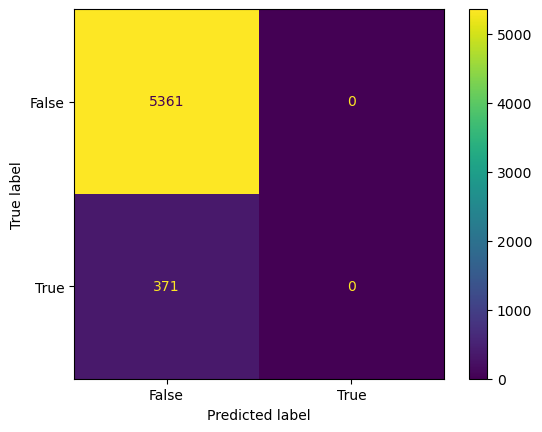

In [179]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay

confusion_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()